# Meditation study - data preparation

This notebook contains all the steps to pre-process the data from the experiment and the survey.

First, the **survey data** are pre-processed, then the **experiment data** for each participant are transformed into a single dataframe and finally, both data sets are merged into one **final data** set which will be used for further analysis.

---

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

---

## Survey data
### Load survey data
Data from the survey are saved in a dataframe `survey_data`.

In [2]:
survey_data = pd.read_csv('data.csv')
survey_data

,participant,age_1,gender_1,qualification_1,employment_1,employment_2,employment_3,employment_4,employment_5,employment_6,...,duration_1,experience_1,style_1,style_specification_1,sart_1,endcode,CLIENT_start,TIME_start,TIME_end,TIME_total
0,s.849fa5ee-30eb-454e-897f-017723f70cbf.txt,1,2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,sart2.2024-05-22-0639.data.849fa5ee-30eb-454e-...,GzJUvEEtmT,2024-04-22-10-55,2024-05-22-05-55,2024-05-22-06-39,44.0
1,s.7bc52b6a-8df7-49ae-934a-d75c152a38d8.txt,2,1,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,4.0,3.0,waking up app (sam harris),sart2.2024-05-29-1138.data.7bc52b6a-8df7-49ae-...,g3LmvfYCtD,2024-04-29-11-28,2024-05-29-11-28,2024-05-29-11-38,10.0
2,s.5b365e94-8417-43b4-862c-40150a86ae5b.txt,2,1,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,2.0,3.0,NaN,sart2.2024-05-22-1353.data.5b365e94-8417-43b4-...,v7xFdMPbD9,2024-04-22-13-43,2024-05-22-13-43,2024-05-22-13-53,10.0
3,s.be79b70a-dd75-4d1b-ac0f-ac66abec67a4.txt,2,2,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,3.0,3.0,NaN,sart2.2024-06-01-1748.data.be79b70a-dd75-4d1b-...,hQuHPDYJ9u,2024-05-01-17-40,2024-06-01-17-40,2024-06-01-17-48,8.0
4,s.f55c07cf-a046-4c4f-9283-652d1e529dc0.txt,3,1,2.0,0.0,1.0,0.0,0.0,0.0,1.0,...,2.0,2.0,2.0,NaN,sart2.2024-05-22-2159.data.f55c07cf-a046-4c4f-...,rfQt9rhtuM,2024-04-22-21-51,2024-05-22-21-51,2024-05-22-21-59,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,s.fe06bf67-6b0a-4d44-a1a8-a6ff77aaf5da.txt,2,1,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,3.0,3.0,NaN,sart2.2024-05-31-1710.data.fe06bf67-6b0a-4d44-...,Y3GhuPtfJD,2024-04-31-17-00,2024-05-31-17-00,2024-05-31-17-10,10.0
165,s.fe327b9b-c21f-48d1-95cc-aff170ad8a65.txt,2,1,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,sart2.2024-05-26-2001.data.fe327b9b-c21f-48d1-...,YEQxwGxvvD,2024-04-26-19-52,2024-05-26-19-52,2024-05-26-20-01,9.0
166,s.e8e337c2-22fe-43c9-ac44-8a8f4c0738dc.txt,3,1,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2024-04-23-16-16,2024-05-23-16-16,NaN,NaN
167,s.c1f99a25-31f0-445f-8ef3-b63152619672.txt,2,2,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2024-05-24-01-01,2024-06-24-01-01,2024-06-24-01-02,1.0


### Exclude incomplete data
Data from participants with a psychologial or cognitive disorder are removed.

In [3]:
survey_data = survey_data.drop(survey_data[survey_data.disorder_1 == 1].index)

Data from participants who have not finished the experiment are removed.

In [4]:
# Identify rows where both 'sart_1' and 'endcode' are empty, i.e. no experiment data exists, no endcode was generated
rows_to_drop = survey_data['sart_1'].isna() & survey_data['endcode'].isna()

# Drop these rows
survey_data = survey_data[~rows_to_drop]

### Remove unnecessary columns
Columns which are not needed anymore are removed.

In [5]:
survey_data = survey_data.drop(columns=['disorder_1','sart_1','endcode', 'CLIENT_start', 'TIME_start', 'TIME_end', 'TIME_total'])

### Rename columns
For readability, all columns are renamed and the suffix "_1" is removed (except for `employment_1`).

In [6]:
survey_data.columns = [col.replace('_1', '') if col != 'employment_1' else col for col in survey_data.columns]

### Combine multiple choice employment columns
The participants could choose multiple options when they were asked about their employment status. Each of the 8 options is one binary variable in the dataset. These 8 variables will now be combined into a new variable `employment`.

In [7]:
# Combine the binary variables into a single categorical variable
def combine_options(row):
    selected_options = []
    if row['employment_1'] == 1:
        selected_options.append('full-time')
    if row['employment_2'] == 1:
        selected_options.append('part-time')
    if row['employment_3'] == 1:
        selected_options.append('unemployed')
    if row['employment_4'] == 1:
        selected_options.append('self-employed')
    if row['employment_5'] == 1:
        selected_options.append('home-maker')
    if row['employment_6'] == 1:
        selected_options.append('student')
    if row['employment_7'] == 1:
        selected_options.append('retired')
    if row['employment_8'] == 1:
        selected_options.append('other')
    
    # Join the selected options into a single string
    return '+'.join(selected_options) if selected_options else 'None'

# Insert the new variable in the data set
survey_data.insert(4, 'employment', survey_data.apply(combine_options, axis=1))

Now the 8 binary variables for the employment status are removed.

In [8]:
survey_data = survey_data.drop(columns=['employment_1','employment_2','employment_3','employment_4','employment_5','employment_6','employment_7','employment_8'])
survey_data

,participant,age,gender,qualification,employment,screentime,socialmedia,computergames,exercise,sleep,mood,regularity,duration,experience,style,style_specification
0,s.849fa5ee-30eb-454e-897f-017723f70cbf.txt,1,2,1.0,student,6 hours,4 hours,2.0,4.0,2.0,4.0,1.0,NaN,NaN,NaN,NaN
1,s.7bc52b6a-8df7-49ae-934a-d75c152a38d8.txt,2,1,2.0,student,3,1,1.0,4.0,3.0,4.0,2.0,1.0,4.0,3.0,waking up app (sam harris)
2,s.5b365e94-8417-43b4-862c-40150a86ae5b.txt,2,1,2.0,student,3,0,2.0,4.0,3.0,10.0,2.0,1.0,2.0,3.0,NaN
3,s.be79b70a-dd75-4d1b-ac0f-ac66abec67a4.txt,2,2,2.0,student,2,2,3.0,3.0,3.0,8.0,4.0,1.0,3.0,3.0,NaN
4,s.f55c07cf-a046-4c4f-9283-652d1e529dc0.txt,3,1,2.0,part-time+student,7,6,2.0,3.0,3.0,7.0,3.0,2.0,2.0,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,s.44c76f29-0a42-4c3c-a182-24db2b3e9b18.txt,2,1,2.0,student,5,"4,5",2.0,3.0,3.0,3.0,1.0,NaN,NaN,NaN,NaN
163,s.7e15f090-b453-4393-8ebd-d4e6b552bbe1.txt,2,1,4.0,part-time+student,2,2,1.0,4.0,3.0,5.0,2.0,1.0,2.0,3.0,NaN
164,s.fe06bf67-6b0a-4d44-a1a8-a6ff77aaf5da.txt,2,1,2.0,student,4,2,1.0,4.0,3.0,7.0,2.0,1.0,3.0,3.0,NaN
165,s.fe327b9b-c21f-48d1-95cc-aff170ad8a65.txt,2,1,2.0,student,4,3,1.0,4.0,1.0,3.0,1.0,NaN,NaN,NaN,NaN


### Screentime and socialmedia data
For the questions regarding screen time and social media, participants were asked to enter free-form text answers. The responses are transformed into a standardized format.

In [9]:
# Extract screentime data to list and inspect values
screentime = survey_data['screentime'].tolist()
print(screentime)

['6 hours', '3', '3', '2', '7', '4', '3', '2', '5', '3', '3', '2', '3h14min', '5', '7', '3', '3', '4', '4', '1,5', '2,5', '3', '2', '6', '2 or 3', '2,5 h', '4', '2', '5', '5', '4', '3', '2', '1.5', '5', '2', '4', '4', '5', '5', '3', '4', '8', '5', '4', '2,5', '2', '4', '2', '2', '3', '4', '?', '2', '3', '4', '4', '4', '3,5', '2', '2', '5', '2', '3', '3', '2', '2', '2,5', '1.5', '6', '2', '3', '4-5', '1,5', '5', '1', '4', '1.5', '3', '8', '3', '3', '4', '3', '5', '1', '5', '7', '3', '3', '6', '2', '2', '7', '1.5', '3', '3', '4', '3.5', '2', '4,5', '2', '4', '2', '3', '3', '3', '4', '2', '4', '2,5', '1,5', '3', '2', '4', '3', '3', '3', '8hours', '2', '4', '4', '5', '4', '4', '2', '2', '4', '5', '4,5', '4', '3', '2.5', '4.5', '2', '6', '4', '5', '2', '4', '4', '3']


In [10]:
# Extract socialmedia data to list and inspect values
socialmedia = survey_data['socialmedia'].tolist()
print(socialmedia)

['4 hours', '1', '0', '2', '6', '2', '3', '1', '1', '2', '2', '1', '1', '3', '3', '2', '1', '2', '3.5', '0,5', '1', '2,5', '2', '5', '2', '1,5h', '3', '2', '2', '1', '0', '1,5', '0,5', '0.5', '4', '1,5', '3', '3', '3', '1', '1,5', '3', '8', '2', '3', '1', '0', '1', '0,5', '0', '0.25', '3', '24', '2', '1', '2', '3', '1', '1,5', '1', '1,5', '3.5', '1', '2', '1', '0.75', '1', '3', '0.3', '2', '1', '0', '1-2', '0', '4', '0,5', '2', '0.1', '3', '2', '0.5', '2', '3', '1', '2', '1-2', '3', '6', '1', '0,75', '3', '1', '0.3', '2', '0.15', '1', '0.5', '4', '1.5', '0', '4', '1', '3.5', '0', '0', '2', '1', '3', '1', '3', '1', '2', '2,5', '0.25', '1', '0,5', '0', '0,5', '5hours', '1', '0', '3', '4', '4', '2', '1', '1,5', '2', '2', '3', '0', '1', '0.2', '4', '1,5', '6', '3', '4,5', '2', '2', '3', '0.5']


In [11]:
# Function to transform every answer to a float
def preprocess_time_data(time_list):
    processed_list = []
    
    for time in time_list:
        # Handle special case: '3h14min'
        time = re.sub(r'3h14min', '3.23', time)
        
        # Handle special case: '24' (probably 24 minutes -> 0.4 hours)
        time = re.sub(r'24', '0.4', time)
            
        # Remove 'h', 'hours', 'min', and '?' 
        time = re.sub(r'hours?|min|h|\?', '', time)
        
        # Replace commas with periods
        time = time.replace(',', '.')
        
        # Handle ranges by taking the average
        if '-' in time:
            range_vals = time.split('-')
            avg_val = (float(range_vals[0]) + float(range_vals[1])) / 2
            time = str(avg_val)
        
        # Handle "or" cases by taking the average
        elif 'or' in time:
            or_vals = time.split('or')
            avg_val = (float(or_vals[0]) + float(or_vals[1])) / 2
            time = str(avg_val)
        
        # Convert to float if possible
        try:
            time = float(time)
        except ValueError:
            time = None
            
        processed_list.append(time)
    
    return processed_list

# Use function on screentime and socialmedia data
screentime_processed = preprocess_time_data(screentime)
socialmedia_processed = preprocess_time_data(socialmedia)

# Check results
print('Screentime:', screentime_processed)
print('Socialmedia:', socialmedia_processed)

Screentime: [6.0, 3.0, 3.0, 2.0, 7.0, 4.0, 3.0, 2.0, 5.0, 3.0, 3.0, 2.0, 3.23, 5.0, 7.0, 3.0, 3.0, 4.0, 4.0, 1.5, 2.5, 3.0, 2.0, 6.0, 2.5, 2.5, 4.0, 2.0, 5.0, 5.0, 4.0, 3.0, 2.0, 1.5, 5.0, 2.0, 4.0, 4.0, 5.0, 5.0, 3.0, 4.0, 8.0, 5.0, 4.0, 2.5, 2.0, 4.0, 2.0, 2.0, 3.0, 4.0, None, 2.0, 3.0, 4.0, 4.0, 4.0, 3.5, 2.0, 2.0, 5.0, 2.0, 3.0, 3.0, 2.0, 2.0, 2.5, 1.5, 6.0, 2.0, 3.0, 4.5, 1.5, 5.0, 1.0, 4.0, 1.5, 3.0, 8.0, 3.0, 3.0, 4.0, 3.0, 5.0, 1.0, 5.0, 7.0, 3.0, 3.0, 6.0, 2.0, 2.0, 7.0, 1.5, 3.0, 3.0, 4.0, 3.5, 2.0, 4.5, 2.0, 4.0, 2.0, 3.0, 3.0, 3.0, 4.0, 2.0, 4.0, 2.5, 1.5, 3.0, 2.0, 4.0, 3.0, 3.0, 3.0, 8.0, 2.0, 4.0, 4.0, 5.0, 4.0, 4.0, 2.0, 2.0, 4.0, 5.0, 4.5, 4.0, 3.0, 2.5, 4.5, 2.0, 6.0, 4.0, 5.0, 2.0, 4.0, 4.0, 3.0]
Socialmedia: [4.0, 1.0, 0.0, 2.0, 6.0, 2.0, 3.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 3.0, 3.0, 2.0, 1.0, 2.0, 3.5, 0.5, 1.0, 2.5, 2.0, 5.0, 2.0, 1.5, 3.0, 2.0, 2.0, 1.0, 0.0, 1.5, 0.5, 0.5, 4.0, 1.5, 3.0, 3.0, 3.0, 1.0, 1.5, 3.0, 8.0, 2.0, 3.0, 1.0, 0.0, 1.0, 0.5, 0.0, 0.25, 3.0, 

In [12]:
# Replace screentime and socialmedia data in survey_data
survey_data['screentime'] = screentime_processed
survey_data['socialmedia'] = socialmedia_processed

### Rename meditation styles and non-meditators
The variable `style` is converted into a categorical variable with the names of the different meditation styles as levels. This variable will be used to differentiate between the experimental groups later. If the question was skipped (null value), the participant is a non-meditator.

In [13]:
survey_data['style'].replace({1: 'ADM', 2: 'NDM', 3: 'CDM'},inplace=True)
survey_data['style'].fillna("Non-Meditators", inplace=True)

### Check optional free-text meditation style specification
The free-text answers are examined with regard to the specific meditation practice to check if they are consistent with the choice of meditation style (ADM, CDM, NDM).

In [14]:
# Group by style and aggregate style specifications into lists
grouped_style = survey_data.groupby('style')['style_specification'].apply(list).reset_index()

# Function to remove NaN values from lists
def remove_nan_from_list(value_list):
    return [x for x in value_list if pd.notna(x)]

# Apply the function to remove NaN values
grouped_style['style_specification'] = grouped_style['style_specification'].apply(remove_nan_from_list)

# Convert to dictionary
style = grouped_style.set_index('style')['style_specification'].to_dict()

# Display the free text answers
style

{'ADM': ['Metta Meditation und Tai Chi'],
 'CDM': ['waking up app (sam harris)',
  'Vipassana meditation',
  'vipassana meditation',
  'Vipassana',
  'breath exercises',
  'focused attention'],
 'NDM': [],
 'Non-Meditators': []}

All the specifications fit into the the chosen category.
Since the specific style is not needed for further anaysis, the column is deleted.

In [15]:
survey_data = survey_data.drop(columns=['style_specification'])

### Modify participant ID
In order to merge the `survey_data` with the `experiment_data` later, the participant ID needs to be in the same format.

In [16]:
# Remove the suffix 's.' from participants
survey_data['participant'] = survey_data['participant'].str[2:]

In [17]:
# Check the first few rows to verify the changes
print(survey_data['participant'].head())

0    849fa5ee-30eb-454e-897f-017723f70cbf.txt
1    7bc52b6a-8df7-49ae-934a-d75c152a38d8.txt
2    5b365e94-8417-43b4-862c-40150a86ae5b.txt
3    be79b70a-dd75-4d1b-ac0f-ac66abec67a4.txt
4    f55c07cf-a046-4c4f-9283-652d1e529dc0.txt
Name: participant, dtype: object


### Fix remaining error
For one participant in the non-meditating group, the `duration` and `experience` questions were erroneously not skipped.

In [18]:
conditions = survey_data.groupby(['style', 'duration', 'experience', 'regularity'], sort=True).size().reset_index(name='Count')
conditions

,style,duration,experience,regularity,Count
0,ADM,1.0,2.0,2.0,2
1,ADM,1.0,3.0,2.0,1
2,ADM,1.0,4.0,5.0,1
3,CDM,1.0,1.0,2.0,6
4,CDM,1.0,1.0,4.0,2
5,CDM,1.0,1.0,5.0,1
6,CDM,1.0,2.0,2.0,16
7,CDM,1.0,2.0,3.0,1
8,CDM,1.0,2.0,4.0,2
9,CDM,1.0,3.0,2.0,13


The answers will be removed.

In [19]:
# Remove duration and experience data from non-meditator 
survey_data.loc[survey_data['style'] == 'Non-Meditators', 'duration'] = ''
survey_data.loc[survey_data['style'] == 'Non-Meditators', 'experience'] = ''

In [20]:
# Check to verify the changes
conditions = survey_data.groupby(['style', 'regularity', 'duration', 'experience'], sort=True).size().reset_index(name='Count')
conditions

,style,regularity,duration,experience,Count
0,ADM,2.0,1.0,2.0,2
1,ADM,2.0,1.0,3.0,1
2,ADM,5.0,1.0,4.0,1
3,CDM,2.0,1.0,1.0,6
4,CDM,2.0,1.0,2.0,16
5,CDM,2.0,1.0,3.0,13
6,CDM,2.0,1.0,4.0,8
7,CDM,2.0,2.0,4.0,1
8,CDM,3.0,1.0,2.0,1
9,CDM,3.0,1.0,3.0,1


### Change data type
The values of the variables `qualification`, `computergames`, `exercise`, `sleep`, `mood`, `regularity`, `duration`, and `experience` are changed to integers.

In [21]:
# Fill missing values from non-meditator with 0
survey_data['duration'].replace({'': 0},inplace=True)
survey_data['experience'].replace({'': 0},inplace=True)

# Convert columns to integers
survey_data = survey_data.astype({
    'qualification': 'Int64',
    'computergames': 'Int64', 
    'exercise': 'Int64',
    'sleep': 'Int64',
    'mood': 'Int64',
    'regularity': 'Int64',
    'duration': 'Int64',
    'experience': 'Int64'
})

In [22]:
# Check data types
survey_data.dtypes

participant       object
age                int64
gender             int64
qualification      Int64
employment        object
screentime       float64
socialmedia      float64
computergames      Int64
exercise           Int64
sleep              Int64
mood               Int64
regularity         Int64
duration           Int64
experience         Int64
style             object
dtype: object

### Check for duplicates
The data set is checked for duplicates.

In [23]:
if survey_data['participant'].is_unique:
    print("There are no duplicates.")
else:
    print("There are duplicates.")

There are no duplicates.


### Final data set `survey_data`
After pre-processing the data from the survey, this is the resulting data set.

In [24]:
survey_data

,participant,age,gender,qualification,employment,screentime,socialmedia,computergames,exercise,sleep,mood,regularity,duration,experience,style
0,849fa5ee-30eb-454e-897f-017723f70cbf.txt,1,2,1,student,6.0,4.0,2,4,2,4,1,0,0,Non-Meditators
1,7bc52b6a-8df7-49ae-934a-d75c152a38d8.txt,2,1,2,student,3.0,1.0,1,4,3,4,2,1,4,CDM
2,5b365e94-8417-43b4-862c-40150a86ae5b.txt,2,1,2,student,3.0,0.0,2,4,3,10,2,1,2,CDM
3,be79b70a-dd75-4d1b-ac0f-ac66abec67a4.txt,2,2,2,student,2.0,2.0,3,3,3,8,4,1,3,CDM
4,f55c07cf-a046-4c4f-9283-652d1e529dc0.txt,3,1,2,part-time+student,7.0,6.0,2,3,3,7,3,2,2,NDM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,44c76f29-0a42-4c3c-a182-24db2b3e9b18.txt,2,1,2,student,5.0,4.5,2,3,3,3,1,0,0,Non-Meditators
163,7e15f090-b453-4393-8ebd-d4e6b552bbe1.txt,2,1,4,part-time+student,2.0,2.0,1,4,3,5,2,1,2,CDM
164,fe06bf67-6b0a-4d44-a1a8-a6ff77aaf5da.txt,2,1,2,student,4.0,2.0,1,4,3,7,2,1,3,CDM
165,fe327b9b-c21f-48d1-95cc-aff170ad8a65.txt,2,1,2,student,4.0,3.0,1,4,1,3,1,0,0,Non-Meditators


---

## Experiment data
### Get experiment data from all participants
For each participant, a data output file was created containing the following information for each training and real test trial:

|Information|Column|
|-----------|------|
|name of block|1|1|
|number of block|2|
|GO (1) or NO-GO trial (0)|3|
|digit (1-9)|4|
|size of the stimulus (values between 1 (smallest) and 5 (biggest))|5|
|response outcome (0 is error, 1 is correct)|6|
|reaction time in milliseconds|7|

The experiment data text files from all participants are accessed, then the metrics for each participant are calculated and lastly, the data are stored in a new dataframe `experiment_data`.

The following metrics are calculated:
- number of omission errors
- number of commission errors (total and per part of the experiment)
- anticipations
- mean reaction time
- standard deviation reaction time

In [25]:
# Define the directory containing the text files
directory = 'C:/Users/sarah/Documents/Studium/Bachelorarbeit/Data/final/data/experiment_data'

# Initialize lists to store data
file_names = []
num_om_errors = []
num_com_errors = []
num_com_errors_1 = []
num_com_errors_2 = []
num_com_errors_3 = []
anticipations = []
mean_reaction_times = []
std_reaction_times = []

# Function to determine the part of the experiment based on the row number
# training trials: 1-18
def get_experiment_part(row_number):
    if 19 <= row_number < 94: # first part of realtest trials
        return 1
    elif 94 <= row_number < 169: # second part of realtest trials
        return 2
    elif 169 <= row_number <= 243: # third part of realtest trials
        return 3
    else:
        return None

# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.txt'):
        file_path = os.path.join(directory, filename)
        
        # Read the content of the text file
        with open(file_path, 'r') as file:
            lines = file.readlines()
        
        # Process the data to calculate errors and reaction times
        om_errors = 0
        com_errors = 0
        com_errors_1 = 0
        com_errors_2 = 0
        com_errors_3 = 0
        
        anticipations_counts = 0
        
        reaction_times = []
        
        i = 0 # counter for get_experiment_part
        
        for line in lines:
            
            i += 1
            
            # Split the line into components (columns)
            data = line.strip().split()
            
            # Extract the relevant components
            name_block = data[0]
            number_block = int(data[1])
            rt = float(data[6])
            go_nogo = int(data[2])
            error = int(data[5])
            
            # Skip the training blocks
            if name_block == 'training':
                continue
            
            # Collect error data for calculation
            om_error = 0 # omission errors
            com_error_1 = 0 # commission errors 1st part
            com_error_2 = 0 # commission errors 2nd part
            com_error_3 = 0 # commission errors 3rd part
            
            # Distinguish between GO and NO-GO trials and experiment part
            # 0 is NO-GO condition, 1 is GO condition
            # 0 is error, 1 is correct
            if go_nogo == 0:
                if get_experiment_part(i) == 1:
                    if error == 0:
                        com_error_1 = 1
                    else:
                        com_error_1 = 0
                elif get_experiment_part(i) == 2:
                    if error == 0:
                        com_error_2 = 1
                    else:
                        com_error_2 = 0
                elif get_experiment_part(i) == 3:
                    if error == 0:
                        com_error_3 = 1
                    else:
                        com_error_3 = 0
            else:
                if error == 0:
                    om_error = 1
                else:
                    om_error = 0
            
            # Calculate the number of omission and commission errors
            om_errors += om_error 
            com_errors_1 += com_error_1
            com_errors_2 += com_error_2
            com_errors_3 += com_error_3
            com_errors = com_errors_1 + com_errors_2 + com_errors_3
                        
            # Calculate number of anticipations
            if rt < 100:
                anticipations_counts += 1
            
            # Store reaction times of the GO condition
            # (reaction time of all correct NO GO trials is 900 ms and would distort the mean if included in the calculation)
            if go_nogo == 1:
                reaction_times.append(rt)
        
        # Calculate the mean reaction time
        if reaction_times:  # To avoid division by zero
            mean_reaction_time = sum(reaction_times) / len(reaction_times)
            std_reaction_time = np.std(reaction_times)
        else:
            mean_reaction_time = None
            std_reaction_time = None
        
        # Store the results
        file_names.append(filename)
        num_om_errors.append(om_errors)
        num_com_errors.append(com_errors)
        num_com_errors_1.append(com_errors_1)
        num_com_errors_2.append(com_errors_2)
        num_com_errors_3.append(com_errors_3)
        anticipations.append(anticipations_counts)
        mean_reaction_times.append(mean_reaction_time)
        std_reaction_times.append(std_reaction_time)
                
# Create a dataframe with the collected data
data = {
    'participant': file_names,
    'om_errors': num_om_errors,
    'com_errors': num_com_errors,
    'com_errors_1': num_com_errors_1,
    'com_errors_2': num_com_errors_2,
    'com_errors_3': num_com_errors_3,
    'anticipations': anticipations,
    'mean_RT': mean_reaction_times,
    'sd_RT': std_reaction_times
}

experiment_data = pd.DataFrame(data)

In [26]:
# Check data types
experiment_data.dtypes

participant       object
om_errors          int64
com_errors         int64
com_errors_1       int64
com_errors_2       int64
com_errors_3       int64
anticipations      int64
mean_RT          float64
sd_RT            float64
dtype: object

In [27]:
# Display the new data set
experiment_data

,participant,om_errors,com_errors,com_errors_1,com_errors_2,com_errors_3,anticipations,mean_RT,sd_RT
0,sart2.2024-05-21-1802.data.09fc3c2f-8d69-40ba-...,0,8,2,3,3,115,100.380,69.422875
1,sart2.2024-05-21-1809.data.b84707db-53d2-47d5-...,5,8,1,2,5,28,304.480,194.806210
2,sart2.2024-05-21-1818.data.a0d97f3e-6bdf-4ba1-...,0,3,1,0,2,94,108.575,55.540925
3,sart2.2024-05-21-1818.data.ee56a6e6-ff39-4e86-...,0,1,0,1,0,23,229.045,89.290610
4,sart2.2024-05-21-1857.data.bc94bcce-d4a4-4218-...,3,10,3,3,4,39,257.465,184.112109
...,...,...,...,...,...,...,...,...,...
139,sart2.2024-06-12-0144.data.e170dc53-2f0b-4d0b-...,0,2,2,0,0,1,334.265,121.701868
140,sart2.2024-06-12-1032.data.85b1e823-e06c-4b0b-...,0,6,2,2,2,86,128.620,84.170990
141,sart2.2024-06-15-1506.data.6f6ed8d4-16d4-4c86-...,0,7,3,3,1,59,129.810,71.070978
142,sart2.2024-06-17-1116.data.d50fc4a4-ddb4-4aa0-...,0,2,1,0,1,44,231.365,141.809914


### Modify participant ID
In order to merge the `survey_data` with the `experiment_data` later, the participant ID needs to be in the same format.

In [28]:
# Crop first 27 characters of participant ID
experiment_data['participant'] = experiment_data['participant'].str[27:]

In [29]:
# Check the first few rows to verify the changes
print(experiment_data['participant'].head())

0    09fc3c2f-8d69-40ba-bacd-106f7f93c4f9.txt
1    b84707db-53d2-47d5-b83e-c73c386bca67.txt
2    a0d97f3e-6bdf-4ba1-bae1-19e1f02a1a00.txt
3    ee56a6e6-ff39-4e86-8992-187ae88f951f.txt
4    bc94bcce-d4a4-4218-a5ea-c247bd1ebcfc.txt
Name: participant, dtype: object


### Check for duplicates
The data set is checked for duplicates.

In [30]:
if experiment_data['participant'].is_unique:
    print("There are no duplicates.")
else:
    print("There are duplicates.")

There are duplicates.


In [31]:
# Inspect the duplicates
duplicate_rows = experiment_data[experiment_data.duplicated(subset=['participant'], keep=False)]
duplicate_rows

,participant,om_errors,com_errors,com_errors_1,com_errors_2,com_errors_3,anticipations,mean_RT,sd_RT
23,6f6534b8-7106-4ca8-81a1-b4c4a0153036.txt,2,10,3,2,5,71,211.445,167.444071
70,6f6534b8-7106-4ca8-81a1-b4c4a0153036.txt,2,10,3,2,5,71,211.445,167.444071
72,6d0afc5e-3955-4ee8-aaab-8ffb18b7d1a6.txt,1,3,1,0,2,98,118.825,88.236355
88,6d0afc5e-3955-4ee8-aaab-8ffb18b7d1a6.txt,1,3,1,0,2,98,118.825,88.236355


In [32]:
# Remove duplicates
experiment_data.drop_duplicates(subset=['participant'], keep='first', inplace=True)

In [33]:
# Check again for duplicates
if experiment_data['participant'].is_unique:
    print("There are no duplicates.")
else:
    print("There are duplicates.")

There are no duplicates.


### Final data set `experiment_data`
After pre-processing the data from the experiment, this is the resulting data set.

In [34]:
experiment_data

,participant,om_errors,com_errors,com_errors_1,com_errors_2,com_errors_3,anticipations,mean_RT,sd_RT
0,09fc3c2f-8d69-40ba-bacd-106f7f93c4f9.txt,0,8,2,3,3,115,100.380,69.422875
1,b84707db-53d2-47d5-b83e-c73c386bca67.txt,5,8,1,2,5,28,304.480,194.806210
2,a0d97f3e-6bdf-4ba1-bae1-19e1f02a1a00.txt,0,3,1,0,2,94,108.575,55.540925
3,ee56a6e6-ff39-4e86-8992-187ae88f951f.txt,0,1,0,1,0,23,229.045,89.290610
4,bc94bcce-d4a4-4218-a5ea-c247bd1ebcfc.txt,3,10,3,3,4,39,257.465,184.112109
...,...,...,...,...,...,...,...,...,...
139,e170dc53-2f0b-4d0b-985f-a657fa1c2ccf.txt,0,2,2,0,0,1,334.265,121.701868
140,85b1e823-e06c-4b0b-9d05-36d8be17132a.txt,0,6,2,2,2,86,128.620,84.170990
141,6f6ed8d4-16d4-4c86-ad21-2b561c0dd3c7.txt,0,7,3,3,1,59,129.810,71.070978
142,d50fc4a4-ddb4-4aa0-8164-16977b4fdc01.txt,0,2,1,0,1,44,231.365,141.809914


---

## Merge `survey_data` and `experiment_data`

Now both dataframes contain data from 142 participants and they can be joined via the participant ID.

In [35]:
# Merge data sets
full_data = pd.merge(survey_data, experiment_data, on='participant', how='left', validate='one_to_one')
full_data

,participant,age,gender,qualification,employment,screentime,socialmedia,computergames,exercise,sleep,...,experience,style,om_errors,com_errors,com_errors_1,com_errors_2,com_errors_3,anticipations,mean_RT,sd_RT
0,849fa5ee-30eb-454e-897f-017723f70cbf.txt,1,2,1,student,6.0,4.0,2,4,2,...,0,Non-Meditators,32,14,6,4,4,84,256.620,298.144521
1,7bc52b6a-8df7-49ae-934a-d75c152a38d8.txt,2,1,2,student,3.0,1.0,1,4,3,...,4,CDM,0,9,3,2,4,83,137.655,85.220690
2,5b365e94-8417-43b4-862c-40150a86ae5b.txt,2,1,2,student,3.0,0.0,2,4,3,...,2,CDM,1,8,1,5,2,145,92.170,104.255077
3,be79b70a-dd75-4d1b-ac0f-ac66abec67a4.txt,2,2,2,student,2.0,2.0,3,3,3,...,3,CDM,0,12,5,4,3,82,132.105,75.499761
4,f55c07cf-a046-4c4f-9283-652d1e529dc0.txt,3,1,2,part-time+student,7.0,6.0,2,3,3,...,2,NDM,2,4,1,1,2,63,173.190,130.216681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,44c76f29-0a42-4c3c-a182-24db2b3e9b18.txt,2,1,2,student,5.0,4.5,2,3,3,...,0,Non-Meditators,0,13,4,5,4,121,114.405,79.601388
138,7e15f090-b453-4393-8ebd-d4e6b552bbe1.txt,2,1,4,part-time+student,2.0,2.0,1,4,3,...,2,CDM,1,3,2,0,1,115,105.875,81.814543
139,fe06bf67-6b0a-4d44-a1a8-a6ff77aaf5da.txt,2,1,2,student,4.0,2.0,1,4,3,...,3,CDM,0,2,1,0,1,27,165.385,70.347898
140,fe327b9b-c21f-48d1-95cc-aff170ad8a65.txt,2,1,2,student,4.0,3.0,1,4,1,...,0,Non-Meditators,13,15,5,2,8,25,369.565,236.014419


### Check data quality
Only data from participants who performed the experiment correctly should be included in the analysis. Therefore, outliers in omission errors, commission errors, and mean reaction time are identified and excluded.

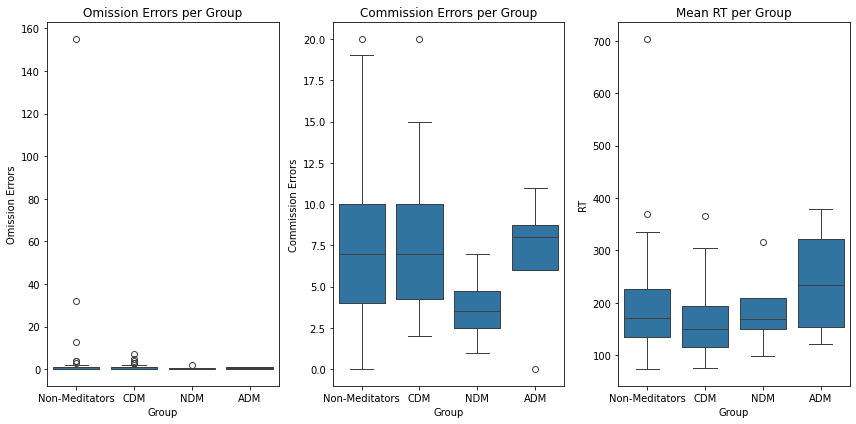

In [36]:
# Set up the matplotlib figure
plt.figure(figsize=(12, 6))

# Create a boxplot for Omission Errors
plt.subplot(1, 3, 1)
sns.boxplot(x='style', y='om_errors', data=full_data)
plt.title('Omission Errors per Group')
plt.xlabel('Group')
plt.ylabel('Omission Errors')

# Create a boxplot for Commission Errors
plt.subplot(1, 3, 2)
sns.boxplot(x='style', y='com_errors', data=full_data)
plt.title('Commission Errors per Group')
plt.xlabel('Group')
plt.ylabel('Commission Errors')

# Create a boxplot for mean RT
plt.subplot(1, 3, 3)
sns.boxplot(x='style', y='mean_RT', data=full_data)
plt.title('Mean RT per Group')
plt.xlabel('Group')
plt.ylabel('RT')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

For omission errors, several outliers exceeding 30 errors (equivalent to 15% of the total number of GO trials) are identified. These participants are excluded from further analysis.

With respect to commission errors and mean RT, no strong outliers were identified.

In [37]:
# Show outliers in omission errors
omission_errors = full_data['om_errors'].tolist()
print(f"Omission errors > 30: {[x for x in omission_errors if x > 30]}")

Omission errors > 30: [32, 155]


In [38]:
# Delete outliers
full_data = full_data.drop(full_data[full_data.om_errors > 30].index)

### Final data set `full_data`
After merging the data from the survey with the data from the experiment and removing outliers, this is the resulting final data set with data from 140 participants.

In [39]:
full_data

,participant,age,gender,qualification,employment,screentime,socialmedia,computergames,exercise,sleep,...,experience,style,om_errors,com_errors,com_errors_1,com_errors_2,com_errors_3,anticipations,mean_RT,sd_RT
1,7bc52b6a-8df7-49ae-934a-d75c152a38d8.txt,2,1,2,student,3.0,1.0,1,4,3,...,4,CDM,0,9,3,2,4,83,137.655,85.220690
2,5b365e94-8417-43b4-862c-40150a86ae5b.txt,2,1,2,student,3.0,0.0,2,4,3,...,2,CDM,1,8,1,5,2,145,92.170,104.255077
3,be79b70a-dd75-4d1b-ac0f-ac66abec67a4.txt,2,2,2,student,2.0,2.0,3,3,3,...,3,CDM,0,12,5,4,3,82,132.105,75.499761
4,f55c07cf-a046-4c4f-9283-652d1e529dc0.txt,3,1,2,part-time+student,7.0,6.0,2,3,3,...,2,NDM,2,4,1,1,2,63,173.190,130.216681
5,96bf5ec7-406f-4b18-96ec-33f10046b0d5.txt,2,1,2,student,4.0,2.0,1,1,4,...,0,Non-Meditators,0,9,1,5,3,117,119.695,87.188715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,44c76f29-0a42-4c3c-a182-24db2b3e9b18.txt,2,1,2,student,5.0,4.5,2,3,3,...,0,Non-Meditators,0,13,4,5,4,121,114.405,79.601388
138,7e15f090-b453-4393-8ebd-d4e6b552bbe1.txt,2,1,4,part-time+student,2.0,2.0,1,4,3,...,2,CDM,1,3,2,0,1,115,105.875,81.814543
139,fe06bf67-6b0a-4d44-a1a8-a6ff77aaf5da.txt,2,1,2,student,4.0,2.0,1,4,3,...,3,CDM,0,2,1,0,1,27,165.385,70.347898
140,fe327b9b-c21f-48d1-95cc-aff170ad8a65.txt,2,1,2,student,4.0,3.0,1,4,1,...,0,Non-Meditators,13,15,5,2,8,25,369.565,236.014419


### Save `full_data` as csv

The pre-processed and merged data set is saved as a csv file to use it for further analysis.

In [40]:
full_data.to_csv('full_data.csv', index = False)